# This Notebook implements Latent Space Walk

# 1. Import Libraries

In [2]:
import os
if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('../')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as dset
from torchvision import transforms
from torch import autograd
import torch.optim as optim

from torchvision.utils import make_grid

import matplotlib.pyplot as plt

import ignite
import ignite.distributed as idist
from ignite.metrics import FID, InceptionScore

import numpy as np

%matplotlib inline

%load_ext autoreload
%autoreload 2

# 2. Params

In [3]:
# device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device = "cpu"

# 3. Load Models

In [33]:
netG = torch.load('./models/netG.pkl').to(device)
netD = torch.load('./models/netD.pkl').to(device)

# 3. Prepare Latent Space Walk

In [22]:
def show_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [27]:
num_images = 8
nz = 100

In [15]:
def interpolate_noises(p1, p2, n_steps=6):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    vectors.append(p1)
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    vectors.append(p2)
    return vectors

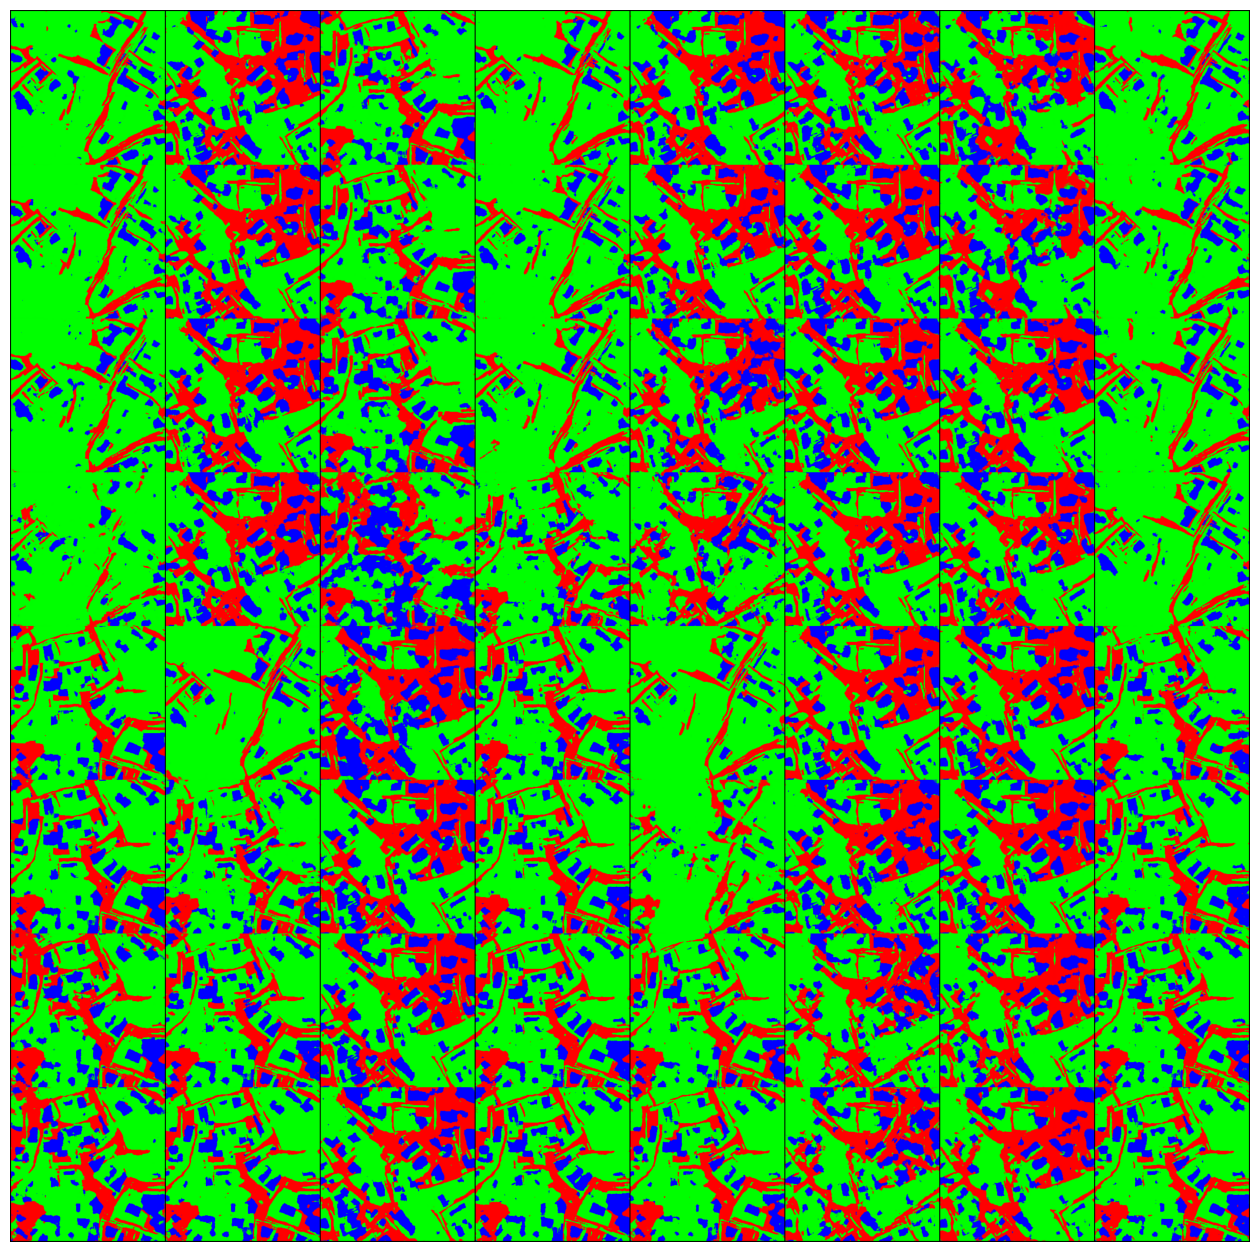

In [42]:
fake_images = []
# generate with interpolation
noise1 = torch.randn(num_images, nz, 1, 1, device=device)
noise2 = torch.randn(num_images, nz, 1, 1, device=device)
vectors = interpolate_noises(noise1, noise2)
for noise in vectors:
    fake = netG(noise)
    fake_images += [fake]
plt.rcParams['figure.figsize'] = [num_images * 2, len(vectors) * 2]
plt.axis('off')
show_images(torch.cat(fake_images, dim=2), num_images=num_images, nrow=num_images)

### Models comparison on fixed noise

In [49]:
class Generator(nn.Module):
    def __init__(self, nz, nc, ngf, drop_rate):
        super(Generator, self).__init__()
        self.softmax = nn.Softmax(dim=1)
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels=nz, out_channels=ngf * 8, kernel_size=2, stride=1, 
                               padding=0, bias=False),
            nn.Dropout2d(p=drop_rate),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 4, kernel_size=4, stride=2, 
                               padding=0, bias=False),
            nn.Dropout2d(p=drop_rate),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(in_channels=ngf * 4, out_channels=ngf * 2, kernel_size=5, stride=3, 
                               padding=1, bias=False),
            nn.Dropout2d(p=drop_rate),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(in_channels=ngf * 2, out_channels=ngf, kernel_size=6, stride=4, 
                               padding=0, bias=False),
            nn.Dropout2d(p=drop_rate),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(in_channels=ngf, out_channels=nc, kernel_size=12, stride=4, 
                               padding=2, bias=False)
        )
    
    def forward(self, input_):
        input_ = self.main(input_)
        return self.softmax(input_)
    
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [52]:
# Create the generator
netG = Generator(nz, 3, 32, 0.05).to(device)
# netG = torch.load('./models/netG.pkl').to('cpu')

# # Handle multi-GPU if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (softmax): Softmax(dim=1)
  (main): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (1): Dropout2d(p=0.05, inplace=False)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (5): Dropout2d(p=0.05, inplace=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), bias=False)
    (9): Dropout2d(p=0.05, inplace=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(4, 4), bias=False)
    (13): Dropout2d(p=0.05, inplace=False

In [46]:
num_images = 5
nz = 512
noise = torch.randn(num_images, nz, 1, 1, device=device)

In [60]:
fake_images[1].shape

torch.Size([5, 3, 300, 300])

In [53]:
fake_images = []

In [68]:
x_true = torch.load('./data/test.pkl')
dataloader = torch.utils.data.DataLoader(x_true, batch_size=5, 
                                             shuffle=True, num_workers=4, drop_last=True)
x_true = next(iter(dataloader))
x_true = x_true[0].to(device)

In [69]:
x_true.shape

torch.Size([5, 3, 300, 300])

In [70]:
fake_images += [x_true]

In [66]:
netG = torch.load('./models/netD_dcgan_bce.pkl').to(device)
noise = torch.randn(num_images, 100, 1, 1, device=device)

In [67]:
fake = netG(noise)
fake_images += [fake]

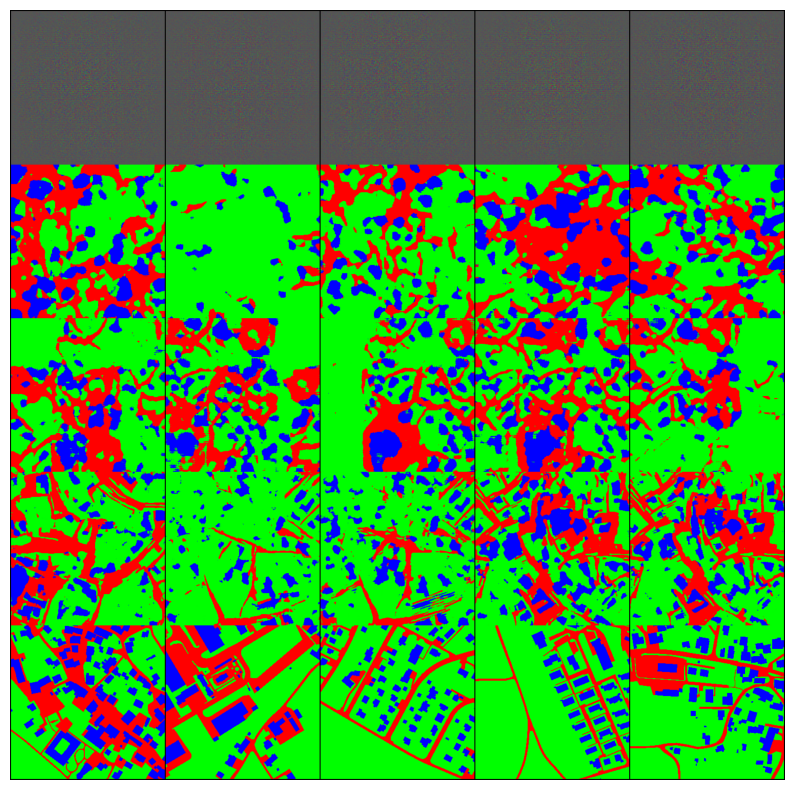

In [71]:
plt.rcParams['figure.figsize'] = [num_images * 2, len(fake_images) * 2]
plt.axis('off')
show_images(torch.cat(fake_images, dim=2), num_images=num_images, nrow=num_images)

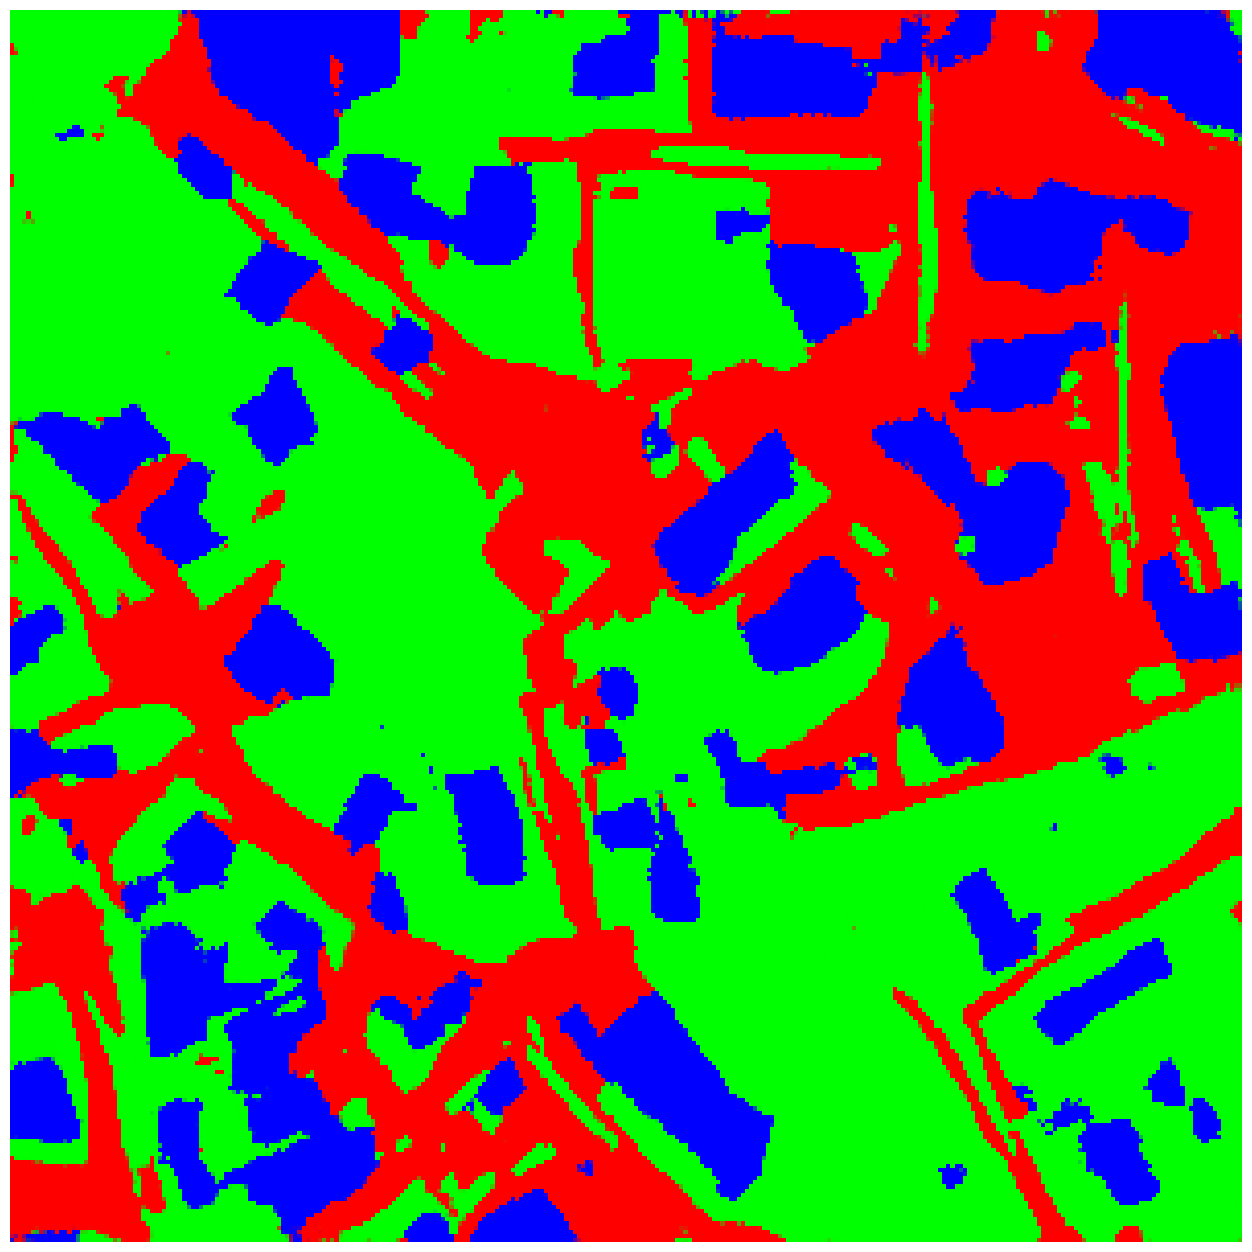

In [37]:
img = fake[2].cpu().detach()

plt.axis('off')
plt.imshow(img.permute(1,2,0), cmap='gray');